# Demos for deep learning.
20210128, Qin ZhaoYu.

<AxesSubplot:>

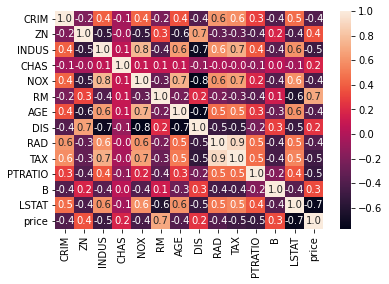

In [4]:
import numpy as np, pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

data = load_boston()
dataframe = pd.DataFrame(data["data"])
dataframe.columns = data["feature_names"]
dataframe["price"] = pd.Series(data["target"])

sns.heatmap(dataframe.corr(), annot=True, fmt=".1f")

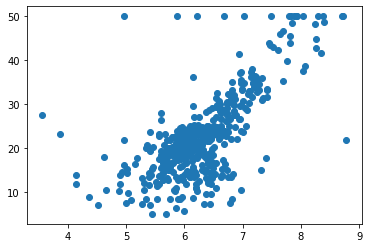

In [3]:
plt.scatter(dataframe["RM"], dataframe["price"])

In [15]:
x = dataframe["RM"]
y = dataframe["price"]
history_notes = {_x : _y for _x, _y in zip(x, y)}
print("6.88 in notes" if 6.88 in history_notes else "6.88 not in notes")

# 把字典的键值对列表按照与目标x的距离排序后切片前三组数据。
similary_xy = np.array(sorted(history_notes.items(), key=lambda xy: (xy[0] - 6.88)**2)[:3])  
print(similary_xy)
np.mean(similary_xy[:, 1])

6.88 not in notes
[[ 6.879 27.5  ]
 [ 6.874 31.2  ]
 [ 6.871 24.8  ]]


27.833333333333332

# 用历史数据来预测未曾见到的过的数据，最直接的方法：
**K-Neighbor-Nearst**

In [18]:
def knn(query_x, history, top_n=3):
    sorted_notes = sorted(history.items(), key=lambda xy: (xy[0] - query_x)**2)
    similary_notes = sorted_notes[:top_n]
    similary_ys = [y for _, y in similary_notes]
    return np.mean(similary_ys)

knn(6.88, history_notes)

27.833333333333332

# 为了更快的获得结果，希望通过拟合函数来获得预测能力
$$ f(rm) = k*rm + b$$   
## Random Approach 
$$ loss(y, \hat{y}) = \frac{1}{N} {\sum_{i \in N}(y_i - \hat{y_i})^2} $$  
$$ loss(y, \hat{y}) = \frac{1}{N} {\sum_{i \in N}(k*rm_i + b - \hat{y_i})^2} $$  

step:0，f(rm) = -88 * rm + -71, loss: 422755.6490560632
step:1，f(rm) = 6 * rm + -7, loss: 115.17242231620553
step:99，f(rm) = 10 * rm + -38, loss: 49.35022272727272
step:140，f(rm) = 7 * rm + -23, loss: 48.150430243082994
step:343，f(rm) = 7 * rm + -22, loss: 46.069699017786554
step:861，f(rm) = 11 * rm + -46, loss: 45.73304483596838


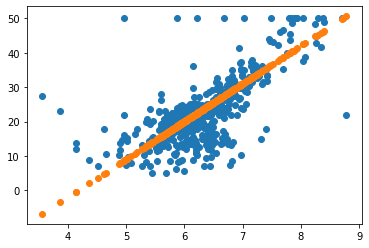

In [26]:
import random
min_loss = float('inf')
best_k, best_b = None, None

def loss(y_hat, y):
    return np.mean((y_hat - y)**2)

for step in range(1000):
    min_v, max_v = -100, 100
    k, b = random.randrange(min_v, max_v), random.randrange(min_v, max_v)
    y_hats = [k*rm_i+b for rm_i in x]
    curr_loss = loss(y_hats, y)

    if curr_loss < min_loss:
        min_loss = curr_loss
        best_k, best_b = k, b
        print('step:{}，f(rm) = {} * rm + {}, loss: {}'.format(step, k, b, curr_loss))

plt.scatter(x, y)
plt.scatter(x, [best_k*_x + best_b for _x in x])

# 蒙特卡洛模拟
我们可以通过监督的方法，来获得更快的函数权值更新

## Supervisor   
$$ Loss(k, b) = \frac{1}{N} {\sum_{i \in N}(k*rm_i + b - \hat{y_i})^2} $$    
$$ \frac{\partial{Loss(k, b)}}{\partial{k}} = \frac{2}{N} {\sum_{i \in N}(k*rm_i+b - \hat{y_i})*rm_i} $$ $$ \frac{\partial{Loss(k, b)}}{\partial{b}} = \frac{2}{N} {\sum_{i \in N}(k*rm_i+b - \hat{y_i})} $$   

therefore  
$$ k_{n+1} = k_{n} + -1*\frac{\partial{Loss(k, b)}}{\partial{k}}*dk $$
$$ b_{n+1} = b_{n} + -1*\frac{\partial{Loss(k, b)}}{\partial{b}}*db $$

step:0，f(rm) = 2.9954617828298584 * rm + 0.5403642731626364, loss: 72.00398662158257
step:1，f(rm) = 3.45371237423031 * rm + 0.5461067231593938, loss: 59.39886398701148
step:2，f(rm) = 3.544738548714192 * rm + 0.5402929996300063, loss: 58.89828352793541
step:3，f(rm) = 3.5636939609658156 * rm + 0.532212993857947, loss: 58.87025787012995
step:4，f(rm) = 3.5685046881912506 * rm + 0.5236899149663461, loss: 58.86167739277639
step:5，f(rm) = 3.5705391494589653 * rm + 0.5150815807477209, loss: 58.85409276824764
step:6，f(rm) = 3.5720284807512765 * rm + 0.5064582151603918, loss: 58.84659777713533
step:7，f(rm) = 3.5734105589920167 * rm + 0.497833599756054, loss: 58.8391191332316
step:8，f(rm) = 3.5747713208159144 * rm + 0.48921043884877374, loss: 58.831646481600515
step:9，f(rm) = 3.576127631985573 * rm + 0.4805892627633034, loss: 58.82417794413036


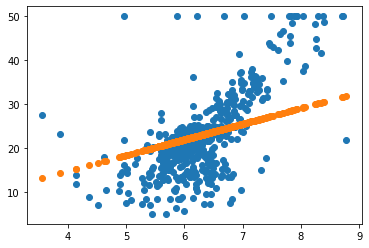

In [31]:
def partial_k(k, b, x, y):
    return 2*np.mean((k*x + b - y)*x)

def partial_b(k, b, x, y):
    return 2*np.mean(k*x + b - y)

k, b = random.random(), random.random()
min_loss = float('inf')
best_k, best_b = None, None
learn_rate = 1e-2

for step in range(10):
    k = k + partial_k(k, b, x, y)*(-1)*learn_rate
    b = b + partial_b(k, b, x, y)*(-1)*learn_rate
    y_hat = k*x + b 
    curr_loss = loss(y_hat, y)

    if curr_loss < min_loss:
        best_k, best_b = k, b
        min_loss = curr_loss
        print('step:{}，f(rm) = {} * rm + {}, loss: {}'.format(step, k, b, curr_loss))

plt.scatter(x, y)
plt.scatter(x, best_k*x+b)

# 非线性的函数的拟合

使用基本的简单的元函数就可以拟合非常多的复杂的函数： 

组合线性函数和非线性函数拟合各种曲线;  
其中，非线性函数常用的有sigmoid函数，又称为“激活函数”，用以拟合非线性关系;  

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

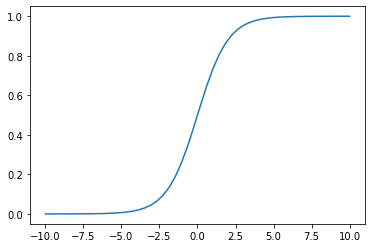

In [8]:
sub_x = np.linspace(-10, 10)
plt.plot(sub_x, sigmoid(sub_x))

In [16]:
import random

def random_linear(x):
    k, b = random.normalvariate(0, 1), random.normalvariate(0, 1)
    return k*x + b

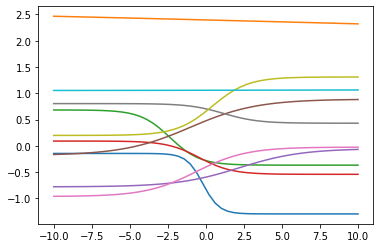

In [13]:
# 通过一个线性函数random_linear和一个非线性函数sigmoid拟合各种曲线
for i in range(10):
    plt.plot(sub_x, random_linear(sigmoid(random_linear(sub_x))))

# 神经网络
一般深度神经网络都超过3层变换。

## 链式求导（前馈网络，FeedForwadNet）  
$$ Loss(k1, k2, b1, b2) = \frac{1}{N} {\sum_{i \in N}(linear2 - \hat{y_i})^2} $$
$$ linear2 = k2*sigmoid(linear1) + b2 $$
$$ sigmoid(linear1) = \frac{1}{1+e^{linear1}} $$
$$ linear1 = k1*x + b1 $$

Therefore, 
$$ \frac{\partial{Loss}}{\partial{k1}} = \frac{\partial{Loss}}{\partial{linear2}} *\frac{\partial{linear2}}{\partial{sigmoid}} *\frac{\partial{sigmoid}}{\partial{linear1}} *\frac{\partial{linear1}}{\partial{k1}} $$ 
$$ \frac{\partial{Loss}}{\partial{b1}}、\frac{\partial{Loss}}{\partial{k2}}、\frac{\partial{Loss}}{\partial{b2}} ...$$

## 梯度下降（反馈网络，FeedBackNet）
$$ k1_{n+1} = k1_{n} + -1*\frac{\partial{Loss}}{\partial{k1}}*dk $$
$$ b1_{n+1} = b1_{n} + -1*\frac{\partial{Loss}}{\partial{b1}}*db $$
$$ k2_{n+1}、b2_{n+1} ...$$

In [6]:
import networkx as nx

In [3]:
class Node():
    def __init__(self, name, inputs=[]):
        self.name = name
        self.inputs = inputs
        self.outputs = []
        for node in self.inputs:
            node.outputs.append(self)

    def forward(self):
        print("Get self value: {}".format(self.name))

    def backward(self):
        pass
    
    def __repr__(self):
        return self.name

class PlaceHolder(Node):
    def __init__(self, name):
        Node.__init__(self, name)

    def forward(self):
        print("::=>Get myself value by humam being")

    def backward(self):
        print("I get my gradient from computer memory directly.")

class Operator(Node):
    def __init__(self, name, inputs=[]):
        Node.__init__(self, name=name, inputs=inputs)

    def forward(self):
        print("::=>Get myself value by calculating inputs:{}".format(self.inputs))

    def backward(self):
        print("Get gradient ∂loss/∂{} and save to memory".format(self.inputs))

        if self.outputs:
            for n in self.inputs:
                print("==:> ∂loss/∂{} = ∂loss/∂{}*∂{}/∂{}".format(n, self.name, self.name, n))
        else:
            print("I am the final node.")

In [4]:
node_x = PlaceHolder("x")
node_k1 = PlaceHolder("k1")
node_b1 = PlaceHolder("b1")
node_linear1 = Operator("linear1", inputs=[node_k1, node_b1, node_x])
node_sigmoid = Operator("sigmoid", inputs=[node_linear1])
node_k2 = PlaceHolder("k2")
node_b2 = PlaceHolder("b2")
node_linear2 = Operator("linear2", inputs=[node_k2, node_b2, node_sigmoid])
node_y_true = PlaceHolder("yTrue")
node_loss = Operator("loss", inputs=[node_linear2, node_y_true])

computing_graph = {
    node_k1: [node_linear1],
    node_b1: [node_linear1],
    node_x : [node_linear1],
    node_linear1: [node_sigmoid],
    node_sigmoid: [node_linear2],
    node_k2: [node_linear2],
    node_b2: [node_linear2],
    node_linear2: [node_loss],
    node_y_true : [node_loss]
}

In [7]:
%matplotlib inline

graph = nx.DiGraph(computing_graph)
layout = nx.layout.spring_layout(graph)


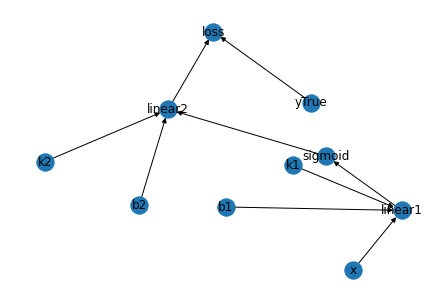

In [8]:
nx.draw(graph, layout, with_labels=True)

In [9]:
# 图计算顺序
order = [node_x, node_k1, node_b1, node_linear1, node_sigmoid, node_k2, node_b2, node_linear2, node_y_true, node_loss]


In [10]:
# 前馈网络，计算得到损失（loss)
for node in order:
    print("I am: {}".format(node))
    node.forward()

I am: x
::=>Get myself value by humam being
I am: k1
::=>Get myself value by humam being
I am: b1
::=>Get myself value by humam being
I am: linear1
::=>Get myself value by calculating inputs:[k1, b1, x]
I am: sigmoid
::=>Get myself value by calculating inputs:[linear1]
I am: k2
::=>Get myself value by humam being
I am: b2
::=>Get myself value by humam being
I am: linear2
::=>Get myself value by calculating inputs:[k2, b2, sigmoid]
I am: yTrue
::=>Get myself value by humam being
I am: loss
::=>Get myself value by calculating inputs:[linear2, yTrue]


In [11]:
# 后馈网络，根据梯度更新节点值
for node in order[::-1]:
    print("I am: {}".format(node))
    node.backward()

I am: loss
Get gradient ∂loss/∂[linear2, yTrue] and save to memory
I am the final node.
I am: yTrue
I get my gradient from computer memory directly.
I am: linear2
Get gradient ∂loss/∂[k2, b2, sigmoid] and save to memory
==:> ∂loss/∂k2 = ∂loss/∂linear2*∂linear2/∂k2
==:> ∂loss/∂b2 = ∂loss/∂linear2*∂linear2/∂b2
==:> ∂loss/∂sigmoid = ∂loss/∂linear2*∂linear2/∂sigmoid
I am: b2
I get my gradient from computer memory directly.
I am: k2
I get my gradient from computer memory directly.
I am: sigmoid
Get gradient ∂loss/∂[linear1] and save to memory
==:> ∂loss/∂linear1 = ∂loss/∂sigmoid*∂sigmoid/∂linear1
I am: linear1
Get gradient ∂loss/∂[k1, b1, x] and save to memory
==:> ∂loss/∂k1 = ∂loss/∂linear1*∂linear1/∂k1
==:> ∂loss/∂b1 = ∂loss/∂linear1*∂linear1/∂b1
==:> ∂loss/∂x = ∂loss/∂linear1*∂linear1/∂x
I am: b1
I get my gradient from computer memory directly.
I am: k1
I get my gradient from computer memory directly.
I am: x
I get my gradient from computer memory directly.


In [12]:
# 更新节点值
for node in order:
    if isinstance(node, PlaceHolder):
        print("Update node: {}.value = {}.value + (-1)*∂loss/∂{}".format(node, node, node))

Update node: x.value = x.value + (-1)*∂loss/∂x
Update node: k1.value = k1.value + (-1)*∂loss/∂k1
Update node: b1.value = b1.value + (-1)*∂loss/∂b1
Update node: k2.value = k2.value + (-1)*∂loss/∂k2
Update node: b2.value = b2.value + (-1)*∂loss/∂b2
Update node: yTrue.value = yTrue.value + (-1)*∂loss/∂yTrue
